In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
# Carga Fichero

import pandas as pd

datos = pd.read_csv('Modelar_UH2022.txt',sep='|',parse_dates=['SAMPLETIME'],infer_datetime_format=True)

In [ ]:
#Modelar_UH2022_10_Contadores.txt
datos[datos['ID']<11].to_csv('Modelar_UH2022_10_Contadores.txt',sep='|',index=False,float_format='%.0f')

In [21]:
datos[datos['ID']<3].to_csv('Modelar_UH2022_2_Contadores.txt',sep='|',index=False,float_format='%.0f')

In [32]:
datos[datos['ID']==2735].to_csv('Modelar_UH2022_Contador_2735.txt',sep='|',index=False,float_format='%.0f')

In [22]:
datos[datos['ID']==2561].to_csv('Modelar_UH2022_Contador_2561.txt',sep='|',index=False,float_format='%.0f')

In [33]:
datos[datos['ID']==167].to_csv('Modelar_UH2022_Contador_167.txt',sep='|',index=False,float_format='%.0f')

In [34]:
datos[datos['ID']==2521].to_csv('Modelar_UH2022_Contador_2521.txt',sep='|',index=False,float_format='%.0f')

# CLASE PARA PROYECTO CAJAMAR

In [1]:
!pip install skforecast

In [34]:
# Librerias

import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import timedelta
from datetime import date
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
#from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster
import model_selection_no_print
#from typing import Union, Optional
from sklearn.preprocessing import StandardScaler
import math
from joblib import dump, load
import pickle


class Contador(object):
    def __init__(self, datos_contador, ID, umbral):
        self.datos_contador = datos_contador
        self.ID = ID
        self.umbral = umbral
        self.Preprocesado()
        self.SinDatos = False  # NO TIENE DATOS DATASET VACIO
        #self.outlier = False
        self.dias = 0
        self.RMSE_Train = 0
        self.RMSE_Test = 0
        self.datos_test = pd.DataFrame()
        self.datos_test_semanal = pd.DataFrame()
        self.Mejor_Parametro = {}
        self.Mejor_Lag = 14 
        
        # {'ID','Dia_1':0,'Dia_2':0,'Dia_3':0,'Dia_4':0,'Dia_5':0,'Dia_6':0','Dia_7':0,'Semana_1':0,'Semana_2':0}
        self.Predicciones = [self.ID,0,0,0,0,0,0,0,0,0]
        
        if not datos_contador.empty:
            # CALCULO LECTURA CONTADOR Y CONSUMO JUNTANDO DECIMALES
            #
            
            self.datos_contador = self.datos_contador.set_index('SAMPLETIME')
            self.datos_contador['CONSUMO'] = self.datos_contador['DELTAINTEGER'] + (self.datos_contador['DELTATHOUSANDTH'] / 100)
            self.datos_contador['LECTURA'] = self.datos_contador['READINGINTEGER'] + (self.datos_contador['READINGTHOUSANDTH'] / 100)

            # CONSUMO POR DIAS
            # RESAMPLE
            
            self.datos_consumo = pd.DataFrame(self.datos_contador['CONSUMO'].resample(rule='1D', closed='left', label ='left').sum())
            self.datos_consumo['CONSUMO_NORM'] = (self.datos_consumo['CONSUMO'] - self.datos_consumo['CONSUMO'].mean()) / self.datos_consumo['CONSUMO'].std()
            # COGER SOLO SEMANAS COMPLETAS
            
            self.datos_consumo_semanal = pd.DataFrame(self.datos_contador['CONSUMO'].resample(rule='1W', closed='left', label ='left',offset='-36h').sum())
            
            # ESTADISTICAS
            self.dias = len(self.datos_consumo.index)
            self.semanas = len(self.datos_consumo_semanal.index)
            #self.datos_consumo['Cuenta'] = self.datos_contador.groupby([self.datos_contador.index.year,self.datos_contador.index.month, self.datos_contador.index.day]).agg({'CONSUMO':'count'}).values
            
            self.fecha_inicio_contador= self.datos_consumo.index[0]
            self.fecha_fin_contador= self.datos_consumo.index[-1]
            
        else:
            self.datos_consumo = pd.DataFrame()
            self.SinDatos = True
            self.fecha_fin_contador = None

        # GENERACION DEL MODELO
        self.modelo()
    
    def __Convertir_fecha(self, serie):
        fechas = []
        for año, mes, dia in serie.index:
            fechas.append(date(año,mes,dia))
        return fechas
    
    def Preprocesado(self):
        # SAMPLETIME READINGINTEGER	READINGTHOUSANDTH	DELTAINTEGER	DELTATHOUSANDTH
        # VALORES  NULOS 
        # VALORES ENTEROS INTERPOLAMOS
        

        self.datos_contador['READINGINTEGER'].interpolate(inplace=True)
        self.datos_contador['DELTAINTEGER'].interpolate(inplace=True)
        
        # VALORES DECIMALES SUSTITUIMOS POR CERO
        self.datos_contador['READINGTHOUSANDTH'].fillna(0,inplace=True)
        self.datos_contador['DELTATHOUSANDTH'].fillna(0,inplace=True)
        
        # ELIMINAR VALORES NEGATIVOS
        indices = self.datos_contador[self.datos_contador['READINGINTEGER'] < 0].index
        self.datos_contador.drop(indices,inplace=True)
        indices = self.datos_contador[self.datos_contador['DELTAINTEGER'] < 0].index
        self.datos_contador.drop(indices,inplace=True)

        # NORMALIZAR

    def modelo(self):
        # DECISION DEL MODELO A TOMAR EN FUNCION DE LA ESTADISTICAS
        # CARGA DEL MODELO
        # PACO
        self.model = None
        if self.dias > self.umbral: 
            if self.fecha_fin_contador == date(2020,1,31):
                # RandomForestRegressor Diario
                self.model = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=14)
                # RandomForestRegressor Semanal Paco
                self.model_Semanal = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=4)
                
            else:
                self.model = self.datos_consumo['CONSUMO'].mean()
        else:
            if self.dias > 0: 
                #if (self.fecha_fin_contador > date(2020,1,17)).bool() :    # HACE MEDIA SI TENEMOS DATOS EN LOS ULTIMOS 14 DIAS
                self.model = self.datos_consumo['CONSUMO'].mean()
                #else:
                #self.model = 0
            else:
                self.model = 0

    def Juntar_Datos(self):
        # REHACE EL MODELO CON LOS MEJORES PARAMETROS
        # JUNTA TODO EN datos_consumo
        # {'max_depth': 3, 'n_estimators': 200}        
        #del self.model
        #if self.dias > umbral:
            #self.model = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=max(self.Mejor_Lag), 
            #                                max_depth=self.Mejor_Parametro['max_depth'],n_estimators=self.Mejor_Parametro['n_estimators'])

        self.datos_consumo = pd.concat([self.datos_consumo,self.datos_test])
        self.datos_test =pd.DataFrame()
        
    

class CajaMar_Water(object):
    def __init__(self,Ruta_Datos,Fecha_Inicio=date(2019,2,1),Fecha_Fin=date(2020,1,31),umbral_modelo=100):
        self.Ruta_Datos = Ruta_Datos
        self.Fecha_Inicio = Fecha_Inicio
        self.Fecha_Fin = Fecha_Fin
        self.umbral_modelo = umbral_modelo
        self.datos = pd.DataFrame()
        self.contadores = []
        self.dias_test = 14     # DIAS QUE SE RESERVAN PARA TEST EMPEZANDO POR LA FECHA MAS RECIENTE
        self.semanas_test = 2   # SEMANAS QUE SE RESERVAN PARA TEST
        self.Cargar_Datos()
        self.RMSE_Test_Promedio=0
        self.RMSE_Test_Suma=0
    

    def Cargar_Datos(self):
        print('CARGANDO DATOS.....')
        self.datos = pd.read_csv(self.Ruta_Datos,sep='|',parse_dates=['SAMPLETIME'],infer_datetime_format=True,encoding='utf-8')
        self.datos.sort_values(by=['ID','SAMPLETIME'],inplace=True)
 
        # GENERANDO CONTADORES
        print('GENERANDO CONTADORES.....')
        for ID in tqdm(pd.unique(self.datos['ID'])):
            # ALMACENAMOS ID DE CONTADOR Y BORRAMOS LA COLUMNA
            self.contadores.append(Contador(self.datos[self.datos['ID']==ID].drop('ID',axis=1),ID,self.umbral_modelo))

        print('PROCESO DE CARGA FINALIZADO')
    
    def PartirDatos(self):
        # Separar datos de entrenamiento y test / validacion (dias=0 no hace validacion)
        if self.dias_test > 0:     
            for contador in tqdm(self.contadores):
                if contador.SinDatos == False:      # COMPROBAMOS QUE HAY ALGUN REGISTRO
                    #if (contador.fecha_fin_contador==self.Fecha_Fin):
                    if contador.dias > self.dias_test + 1:    # COMPROBAMOS QUE HAY SUFICIENTES DATOS PARA HACER PARTICION
                        contador.datos_test = contador.datos_consumo.tail(self.dias_test)
                        contador.datos_consumo = contador.datos_consumo[0:-self.dias_test]
                    if contador.semanas > self.semanas_test + 1:
                        contador.datos_test_semanal = contador.datos_consumo_semanal.tail(self.semanas_test)
                        contador.datos_consumo_semanal = contador.datos_consumo_semanal[0:-self.semanas_test]


    
    def Grid_Search(self,ID,steps):
        # Hiperparámetros del regresor
        param_grid = {'n_estimators': [100,200],
              'max_depth': [3, 5, 10]}

        # Lags utilizados como predictores
        lags_grid = [14, 30]

        resultados_grid = model_selection_no_print.grid_search_forecaster(
                                forecaster         = self.contadores[ID].model,
                                y                  = self.contadores[ID].datos_consumo['CONSUMO'],
                                param_grid         = param_grid,
                                lags_grid          = lags_grid,
                                steps              = steps,
                                refit              = True,
                                metric             = 'mean_squared_error',
                                initial_train_size = len(self.contadores[ID].datos_consumo) - 14,
                                return_best        = True,
                                verbose            = False)
        self.contadores[ID].RMSE_Train = math.sqrt(resultados_grid['metric'].head(1))
        self.contadores[ID].Mejor_Parametro = list(resultados_grid['params'])[0]
        self.contadores[ID].Mejor_Lag = max(list(resultados_grid['lags'].head(1))[0])
        

    def Entrenamiento(self,Grid=False):
        # Entrenamiento de los modelos en self.contadores(lista) 
        # iterar lista y llamar a self.contadores[iter].modelo.train
        # Rellena la variable self.contadores.Predicciones
        indexC = 0
        for contador in tqdm(self.contadores):
            if isinstance(contador.model,ForecasterAutoreg):    # COMPROBAMOS QUE ES UN MODELO
                if Grid:
                    self.Grid_Search(indexC,self.dias_test)
                    #contador.Juntar_Datos() #  JUNTA LOS DATOS PARA LUEGO HACER PREDICT
                
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_NORM'])
                contador.model.fit(y=contador.datos_consumo['CONSUMO'])
                contador.model_Semanal.fit(y=contador.datos_consumo_semanal['CONSUMO'])
                # HAY QUE TENER EN CUENTA CUANDO TERMINAN LOS DATOS
                #predict = contador.model.predict(steps=self.dias_test) * contador.datos_consumo['CONSUMO'].std() + contador.datos_consumo['CONSUMO'].mean()
                predict = contador.model.predict(steps=self.dias_test)
                predict_semanal = contador.model_Semanal.predict(steps=self.semanas_test)
                index = 1
                for predict_dia in predict[0:7]:    # GUARDA 7 DIAS PREDICCION
                    contador.Predicciones[index] = predict_dia
                    index += 1
                #contador.Predicciones[8]=predict[0:7].sum()     # GUARDA SEMANA1 PREDICCION
                #contador.Predicciones[9]=predict[7:14].sum()    # GUARDA SEMANA2 PREDICCION
                contador.Predicciones[8]=predict_semanal[0]              # GUARDA SEMANA1 PREDICCION
                contador.Predicciones[9]=predict_semanal[1]              # GUARDA SEMANA2 PREDICCION
            else:
              for index in range(1,8):
                    contador.Predicciones[index] = contador.model  # GUARDAMOS MEDIA EN LOS 7 DIAS
              contador.Predicciones[8]=contador.model*7     # GUARDAMOS MEDIA SEMANA1
              contador.Predicciones[9]=contador.model*7     # GUARDAMOS MEDIA SEMANA2
            
            indexC += 1
                  

    def Calculo_RMSE(self):
        # Calculo rmse utlizando datos de test
        RMSE_Todos = []
        for contador in tqdm(self.contadores):
            #if contador.dias > 180 and len(contador.datos_test) == self.dias_test:  # VER LIMITE NO DEPENDE DE LA CLASE CONTADOR
            if len(contador.datos_test) == self.dias_test:
                #media_RMSE_semanal=math.sqrt(mean_squared_error([contador.datos_test['CONSUMO'][0:7].sum(), contador.datos_test['CONSUMO'][7:14].sum()] , [contador.Predicciones[8], contador.Predicciones[9]]))
                media_RMSE_semanal=math.sqrt(mean_squared_error(contador.datos_test_semanal['CONSUMO'] , [contador.Predicciones[8], contador.Predicciones[9]]))
                contador.RMSE_Test = 0.5*math.sqrt(mean_squared_error(contador.datos_test['CONSUMO'][0:7],contador.Predicciones[1:8]))+0.5*media_RMSE_semanal
                # Sin raiz
                #media_RMSE_semanal=mean_squared_error([contador.datos_test['CONSUMO'][0:7].sum(), contador.datos_test['CONSUMO'][7:14].sum()] , [contador.Predicciones[8], contador.Predicciones[9]])
                #contador.RMSE_Test = 0.5+mean_squared_error(contador.datos_test['CONSUMO'][0:7],contador.Predicciones[1:8])+0.5*media_RMSE_semanal
                RMSE_Todos.append(contador.RMSE_Test)

        self.RMSE_Test_Suma = sum(RMSE_Todos)
        self.RMSE_Test_Promedio = self.RMSE_Test_Suma / len(RMSE_Todos) 
        
    
    def GenerarResultados(self,equipo='Team2021IA3',numeral=1):
        # Mediante los datos predicciones generamos txt con el formato del datathon
        # Separando campos con “|”, el valor de la predicción en litros, y los decimales con “.” 2 decimales
        # Fichero: "Cajamar_Universitat de València (UV)_Team2021IA3_numeral.txt"
        
        columnas = ['ID','Dia_1','Dia_2','Dia_3','Dia_4','Dia_5','Dia_6','Dia_7','Semana_1','Semana_2']
        datos = []

        for contador in tqdm(self.contadores):
            datos.append(contador.Predicciones)
        
        print('TAMAÑO DE LOS DATOS: ', len(datos), 'x' ,len(datos[0]))
        
        dataset = pd.DataFrame(datos,columns=columnas)
        dataset.to_csv('Cajamar_Universitat de València (UV)_' + equipo + '_' + str(numeral) + '.txt',header=False ,sep='|' ,index=False ,decimal='.' ,float_format='%.2f')
         
    def GraficasEstadisticas(self,contador=0,Test=True):
        # GRÁFICAS DE CONTADORES INDIVIDUALES CON TEST Y PREDICCIONES
        if Test:
            fig, ax = plt.subplots(figsize=(10, 4))
            self.contadores[contador].datos_test['CONSUMO'].plot(ax=ax, label='Test', linewidth=1)
            pd.DataFrame(self.contadores[contador].Predicciones[1:8],index=self.contadores[contador].datos_test['CONSUMO'].index[0:7],columns=['Predicción']).plot(ax=ax, label='Prediccion', linewidth=1)
            ax.set_title('Consumo Agua. RMSE: ' + str(self.contadores[contador].RMSE_Test) + ' Contador: ' + str(contador))
            ax.legend();
        else:
            base = date(2020,2,1)
            index = [base + timedelta(days=x) for x in range(7)]
            index = pd.DataFrame(index)
            index.insert(1, 'SAMPLETIME', [base + timedelta(days=x) for x in range(7)], True)
            index['SAMPLETIME']=pd.to_datetime(index['SAMPLETIME'], format='%Y-%m-%d')
            index=index.set_index('SAMPLETIME')
            index_puro=index.drop([0],axis=1)
            index_puro['Predicción']=Proyecto.contadores[contador].Predicciones[1:8]
            #df_final=pd.DataFrame(index_puro.insert(1, 'Predicción', pd.Series(self.contadores[contador].Predicciones[1:8]), True))

            fig, ax = plt.subplots(figsize=(10, 4))
            self.contadores[contador].datos_consumo['CONSUMO'].plot(ax=ax, label='Consumo', linewidth=1)
            index_puro.plot(ax=ax, label='Predicción', linewidth=1)
            #pd.DataFrame(self.contadores[contador].Predicciones[1:8],index=index_puro,columns=['Predicción']).plot(ax=ax, label='Prediccion', linewidth=1)
            ax.set_title('Consumo Agua. RMSE: ' + str(self.contadores[contador].RMSE_Train) + ' Contador: ' + str(contador))
            ax.legend();

    def Guardar_Modelos(self,Ruta='./modelos/Modelo_ID_'):

        print('GUARDANDO MODELOS.....')
        for contador in tqdm(self.contadores):
            dump(contador.model,Ruta + str(contador.ID))

        

In [37]:
#Proyecto = CajaMar_Water('Modelar_UH2022.txt')
#Proyecto = CajaMar_Water('/content/drive/MyDrive/Modelar_UH2022_10_Contadores.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_10_Contadores.txt',umbral_modelo=367)
Proyecto = CajaMar_Water('Modelar_UH2022_10_Contadores.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_3_Contadores.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2735.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2561.txt')

  0%|          | 0/11 [00:00<?, ?it/s]

CARGANDO DATOS.....
GENERANDO CONTADORES.....


100%|██████████| 11/11 [00:00<00:00, 66.29it/s]

PROCESO DE CARGA FINALIZADO


# DOS MODELOS UNO PARA DIAS Y OTRO PARA SEMANAS

In [36]:
Proyecto.PartirDatos()
Proyecto.Entrenamiento(Grid=True)
Proyecto.Calculo_RMSE()

100%|██████████| 11/11 [00:00<00:00, 1353.20it/s]


In [31]:
Proyecto.RMSE_Test_Promedio

224.40855367885982

In [32]:
Proyecto.contadores[0].datos_consumo_semanal

,CONSUMO
SAMPLETIME,
2019-01-27,479.0
2019-02-03,1815.0
2019-02-10,2022.0
2019-02-17,2248.0
2019-02-24,1918.0
2019-03-03,1941.1
2019-03-10,2483.0
2019-03-17,1991.4
2019-03-24,2146.0


# GRID SEARCH
 # Hiperparámetros del regresor
       #param_grid = {'n_estimators': [100,200],
       #'max_depth': [3, 5, 10]}
       #len(self.contadores[ID].datos_consumo) - 14 
       # Lags utilizados como predictores
       #lags_grid = [14, 30]

In [54]:
Proyecto.PartirDatos()
Proyecto.Entrenamiento(Grid=True)
Proyecto.Calculo_RMSE()
# RELLENADO RMSE_Train y RMSE_Test y model con el mejor modelo
# VOLVEMOS A JUNTAR LOS 14 DIAS
for contador in Proyecto.contadores:
    contador.Juntar_Datos()
Proyecto.Entrenamiento()
Proyecto.GenerarResultados(equipo='GRID')
print(Proyecto.RMSE_Test_Promedio,Proyecto.RMSE_Test_Suma)

100%|██████████| 2747/2747 [00:00<00:00, 1062304.36it/s]

TAMAÑO DE LOS DATOS:  2747 x 10
684.9139472755802 1865020.6784314048


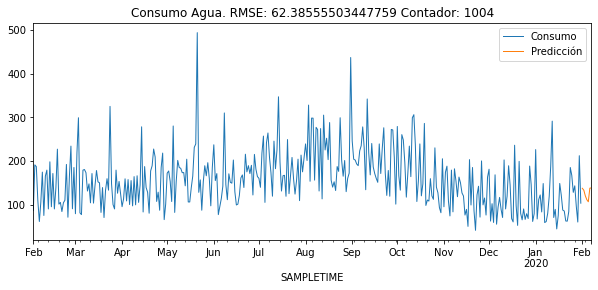

In [119]:
Proyecto.GraficasEstadisticas(1004,Test=False)

In [83]:
Proyecto.Guardar_Modelos()

  0%|          | 2/2747 [00:00<02:46, 16.44it/s]

GUARDANDO MODELOS.....


100%|██████████| 2747/2747 [02:09<00:00, 21.16it/s]


In [47]:
Proyecto.contadores[0].fecha_fin_contador - Proyecto.contadores[0].fecha_inicio_contador + timedelta(days=1)

Timedelta('365 days 00:00:00')

In [39]:
timedelta(Proyecto.contadores[0].dias)

datetime.timedelta(days=365)

In [82]:
#Proyecto.__dict__

file = open('Copia_Proyecto'+'.txt','w')
file.write(pickle.dumps(Proyecto.__dict__))
file.close()

TypeError: write() argument must be str, not bytes

In [ ]:
#Proyecto = CajaMar_Water('Modelar_UH2022.txt')
Proyecto.PartirDatos()
Proyecto.Entrenamiento(Grid=True)
Proyecto.Calculo_RMSE()
# RELLENADO RMSE_Train y RMSE_Test y model con el mejor modelo
# VOLVEMOS A JUNTAR LOS 14 DIAS
for contador in Proyecto.contadores:
    contador.Juntar_Datos()
Proyecto.Entrenamiento()
Proyecto.GenerarResultados(equipo='GRID')

# GUARDAR MODELOS
#Proyecto.Guardar_Modelos()

In [102]:
Proyecto.Guardar_Modelos()

 36%|███▋      | 4/11 [00:00<00:00, 32.78it/s]

GUARDANDO MODELOS.....


100%|██████████| 11/11 [00:00<00:00, 34.73it/s]


In [95]:
for id in range(10):
    print(id,Proyecto.contadores[id].RMSE_Train,Proyecto.contadores[id].RMSE_Test)

0 74.59041362891061 191.74231135280596
1 12.86668364468534 106.58768847799644
2 10.310181899329688 24.866257025645695
3 88.28633929187893 260.65957803786375
4 81.68681227927514 326.57393486791926
5 140.7942285802261 552.6132571273574
6 56.288631127645196 29.903809363050083
7 118.82050171619986 124.71273773299313
8 11.879376969526644 644.7591204702367
9 186.50702521898856 601.7829454369686


In [91]:
Proyecto.contadores[1].RMSE_Test

106.58768847799644

In [26]:
Proyecto.RMSE_Test_Promedio

288.1549377610538

In [20]:
Proyecto.RMSE_Test_Promedio

376.8270715655839

In [ ]:
# SIN PARTIR DATOS PARA GENERAR TXT ANTES GENERAR MÉTODO PARA GUARDAR DATOS
Proyecto = CajaMar_Water('Modelar_UH2022.txt')
Proyecto.Entrenamiento()

# MODELO GANADOR PRUEBA INTERMEDIA RMSE CON SUMA

In [3]:
Proyecto = CajaMar_Water('Modelar_UH2022.txt')
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()

100%|██████████| 2747/2747 [00:02<00:00, 1202.81it/s]


In [4]:
Proyecto.RMSE_Test_Suma

1723348.9862600241

In [5]:
Proyecto.RMSE_Test_Promedio

632.8861499302329

# NUMERAL=1 ENTREGA DE DATOS HACIENDO LA MEDIA

In [8]:
Proyecto = CajaMar_Water('Modelar_UH2022.txt',umbral_modelo=367)
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()
print('RMSE EN TEST ULTIMOS 14 DIAS (MEDIA): ',Proyecto.RMSE_Test_Promedio)
# SIN PARTIR DATOS PARA GENERAR TXT
Proyecto = CajaMar_Water('Modelar_UH2022.txt',umbral_modelo=367)
Proyecto.Entrenamiento()
Proyecto.GenerarResultados(numeral=1)


CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


 29%|██▉       | 804/2747 [00:00<00:00, 8032.86it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:02<00:00, 1262.36it/s]


RMSE EN TEST ULTIMOS 14 DIAS (MEDIA):  1200.8062020214459
CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


100%|██████████| 2747/2747 [00:00<00:00, 1583093.31it/s]

PROCESO DE CARGA FINALIZADO
TAMAÑO DE LOS DATOS:  2747 x 10


# NUMERAL=2 ENTREGA DE DATOS CON DISTINTOS LIMITES DE UMBRAL Y EL MODELO POR DEFECTO. RANDOM FOREST REGRESOR

In [10]:
for umbral in [100,180,270]:
    Proyecto = CajaMar_Water('Modelar_UH2022.txt',umbral_modelo=umbral)
    Proyecto.PartirDatos()
    Proyecto.Entrenamiento()
    Proyecto.Calculo_RMSE()
    print('RMSE EN TEST ULTIMOS 14 DIAS (MEDIA): ',Proyecto.RMSE_Test_Promedio,' UMBRAL: ', umbral)
    # SIN PARTIR DATOS PARA GENERAR TXT
    Proyecto = CajaMar_Water('Modelar_UH2022.txt',umbral_modelo=umbral)
    Proyecto.Entrenamiento()
    Proyecto.GenerarResultados(equipo='UMBRAL',numeral=umbral)

CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


 58%|█████▊    | 1595/2747 [00:00<00:00, 7983.82it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:02<00:00, 1281.55it/s]


RMSE EN TEST ULTIMOS 14 DIAS (MEDIA):  620.7288387410877  UMBRAL:  100
CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


  0%|          | 0/2747 [00:00<?, ?it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:00<00:00, 129869.40it/s]


TAMAÑO DE LOS DATOS:  2747 x 10
CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


  0%|          | 0/2747 [00:00<?, ?it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:02<00:00, 1218.56it/s]


RMSE EN TEST ULTIMOS 14 DIAS (MEDIA):  637.536231110315  UMBRAL:  180
CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


  0%|          | 0/2747 [00:00<?, ?it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:00<00:00, 1460298.24it/s]


TAMAÑO DE LOS DATOS:  2747 x 10
CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


 59%|█████▉    | 1620/2747 [00:00<00:00, 8049.92it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:02<00:00, 1303.33it/s]


RMSE EN TEST ULTIMOS 14 DIAS (MEDIA):  654.9834101993102  UMBRAL:  270
CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


  0%|          | 0/2747 [00:00<?, ?it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:00<00:00, 1501010.04it/s]

TAMAÑO DE LOS DATOS:  2747 x 10


# NUMERAL 2 UMBRAL 50 RANDOM FOREST REGRESOR



In [11]:
Proyecto = CajaMar_Water('Modelar_UH2022.txt',umbral_modelo=50)
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()
print('RMSE EN TEST ULTIMOS 14 DIAS (MEDIA): ',Proyecto.RMSE_Test_Promedio)
# SIN PARTIR DATOS PARA GENERAR TXT
Proyecto = CajaMar_Water('Modelar_UH2022.txt',umbral_modelo=50)
Proyecto.Entrenamiento()
Proyecto.GenerarResultados(equipo='UMBRAL',numeral=50)

CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


100%|██████████| 2747/2747 [01:03<00:00, 43.48it/s]


PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:02<00:00, 1266.47it/s]


RMSE EN TEST ULTIMOS 14 DIAS (MEDIA):  625.399573522973
CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


  0%|          | 0/2747 [00:00<?, ?it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:00<00:00, 82858.12it/s]

TAMAÑO DE LOS DATOS:  2747 x 10


# NUMERAL 2 RANDOM FOREST UMBRAL 100 Y MODIFICACIÓN FECHA DE FIN

In [35]:
Proyecto = CajaMar_Water('Modelar_UH2022.txt',umbral_modelo=100)
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()
print('RMSE EN TEST ULTIMOS 14 DIAS (MEDIA): ',Proyecto.RMSE_Test_Promedio)
# SIN PARTIR DATOS PARA GENERAR TXT
Proyecto = CajaMar_Water('Modelar_UH2022.txt',umbral_modelo=100)
Proyecto.Entrenamiento()
Proyecto.GenerarResultados(equipo='UMBRAL_FECHA_FIN',numeral=100)

CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


 27%|██▋       | 731/2747 [00:00<00:00, 7302.17it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:02<00:00, 1068.47it/s]


RMSE EN TEST ULTIMOS 14 DIAS (MEDIA):  632.8861499302329
CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


  0%|          | 0/2747 [00:00<?, ?it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:00<00:00, 105426.57it/s]

TAMAÑO DE LOS DATOS:  2747 x 10


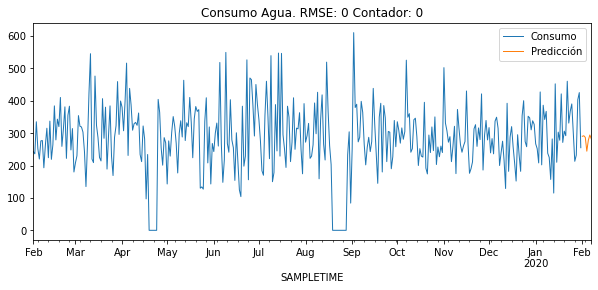

In [12]:
Proyecto.GraficasEstadisticas(Test=False)

# NUMERAL 2. UMBRAL 100 CON EXTRATREESREGRESSOR

In [17]:
Proyecto = CajaMar_Water('Modelar_UH2022.txt',umbral_modelo=100)
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()
print('RMSE EN TEST ULTIMOS 14 DIAS (MEDIA): ',Proyecto.RMSE_Test_Promedio)
# SIN PARTIR DATOS PARA GENERAR TXT
Proyecto = CajaMar_Water('Modelar_UH2022.txt',umbral_modelo=100)
Proyecto.Entrenamiento()
Proyecto.GenerarResultados(equipo='UMBRAL_EXTRA_TREES_',numeral=100)

CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


 29%|██▉       | 791/2747 [00:00<00:00, 7907.41it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:02<00:00, 983.43it/s] 


RMSE EN TEST ULTIMOS 14 DIAS (MEDIA):  661.5675509801729
CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


  0%|          | 0/2747 [00:00<?, ?it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:00<00:00, 75416.98it/s]

TAMAÑO DE LOS DATOS:  2747 x 10


# EVALUANDO MEJOR MODELO

In [31]:
Proyecto = CajaMar_Water('Modelar_UH2022.txt',umbral_modelo=100)
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()

# HAY 117 CONTADORES QUE LA FECHA DE FIN NO ES 31 DE ENERO
for contadores in Proyecto.contadores:
    if contadores.fecha_fin_contador != Proyecto.Fecha_Fin:
        print(contadores.ID, contadores.fecha_fin_contador, contadores.dias, contadores.RMSE_Test)

CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


 29%|██▊       | 783/2747 [00:00<00:00, 7825.40it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:02<00:00, 1091.46it/s]

116 2020-01-26 00:00:00 356 351.01669978784605
167 2020-01-24 00:00:00 356 480.0087433110364
209 2019-09-12 00:00:00 221 0.0
231 2020-01-21 00:00:00 338 2.707559614151996
260 2020-01-28 00:00:00 362 344.680574049081
293 2020-01-26 00:00:00 360 593.4891695568385
371 2020-01-25 00:00:00 359 61.26063990179608
386 2020-01-29 00:00:00 363 198.08181760746268
438 2019-12-24 00:00:00 293 496.849235403081
441 2020-01-22 00:00:00 356 91.28320773387397
525 2020-01-23 00:00:00 357 226.73811399078548
654 2020-01-29 00:00:00 363 662.4690722267934
795 2019-11-24 00:00:00 266 1735.8137417744654
813 2020-01-30 00:00:00 322 26850.21324157027
860 2020-01-29 00:00:00 363 242.26684664849682
969 2020-01-30 00:00:00 364 942.4844469139922
1022 2020-01-23 00:00:00 357 81.71088839752016
1041 None 0 0
1133 2020-01-26 00:00:00 356 115.61139141635249
1174 2020-01-27 00:00:00 360 403.6306478559143
1247 2020-01-26 00:00:00 360 17943.852704328598
1338 2020-01-19 00:00:00 353 11021.806712897429
1367 2019-09-25 00:00:0

In [25]:
for contadores in Proyecto.contadores:
    if contadores.ID == 116:
        print(contadores.datos_consumo)

            CONSUMO
SAMPLETIME         
2019-02-05     0.00
2019-02-06     0.00
2019-02-07     0.00
2019-02-08     0.00
2019-02-09     0.00
...             ...
2020-01-22   282.17
2020-01-23   229.02
2020-01-24   246.24
2020-01-25   246.24
2020-01-26    56.04

[356 rows x 1 columns]


# CORRELACION Y GRAFICAS VARIAS

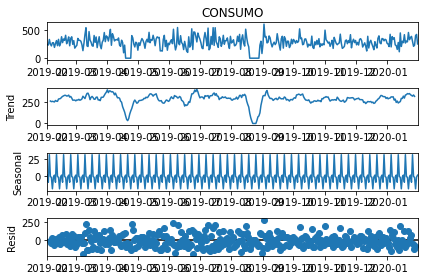

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(Proyecto.contadores[0].datos_consumo['CONSUMO'],model='additive')
decomposition.plot()
plt.show()

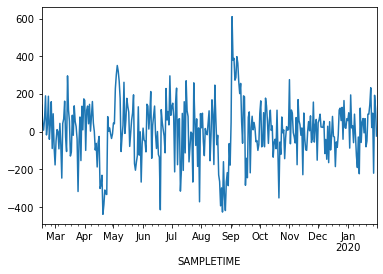

In [57]:
# ESTACIONALIDAD SEMANAL:

datos_semanal = Proyecto.contadores[0].datos_consumo['CONSUMO'].diff(14).dropna()
datos_semanal.plot()
plt.show()

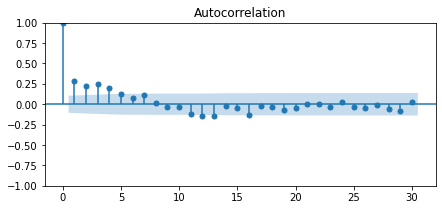

In [76]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(Proyecto.contadores[0].datos_consumo['Consumo'], ax=ax, lags=30)
plt.show()

/Users/felipe/opt/anaconda3/envs/TFM/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


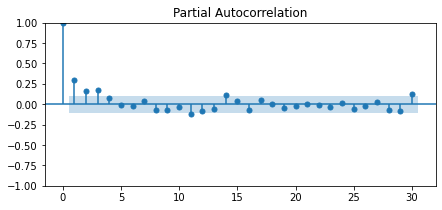

In [77]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(Proyecto.contadores[0].datos_consumo['Consumo'], ax=ax, lags=30)
plt.show()

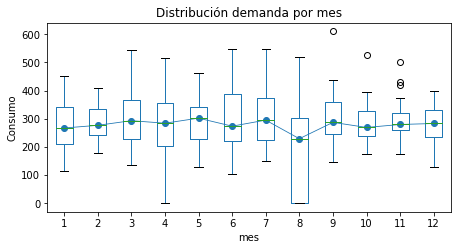

In [91]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
Proyecto.contadores[0].datos_consumo['mes'] = pd.to_datetime(Proyecto.contadores[0].datos_consumo['Fecha']).dt.month
Proyecto.contadores[0].datos_consumo.boxplot(column='Consumo', by='mes', ax=ax,)
Proyecto.contadores[0].datos_consumo.groupby('mes')['Consumo'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Consumo')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

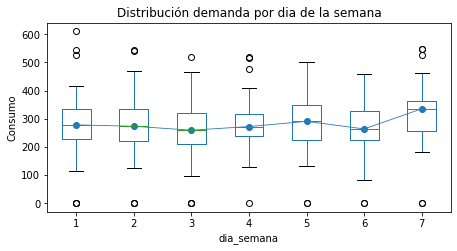

In [94]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
Proyecto.contadores[0].datos_consumo['dia_semana'] = pd.to_datetime(Proyecto.contadores[0].datos_consumo['Fecha']).dt.day_of_week + 1
Proyecto.contadores[0].datos_consumo.boxplot(column='Consumo', by='dia_semana', ax=ax)
Proyecto.contadores[0].datos_consumo.groupby('dia_semana')['Consumo'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Consumo')
ax.set_title('Distribución demanda por dia de la semana')
fig.suptitle('');

2747


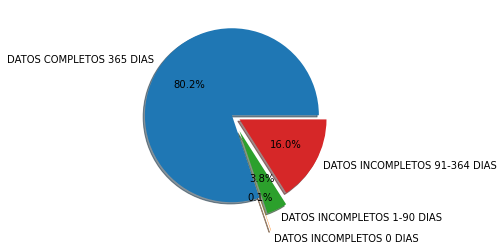

In [113]:
# ESTADISTICAS DATOS

completo = 0
incompleto_0 = 0
incompleto_m_100 = 0
incompleto_M_100 = 0

for contador in Proyecto.contadores:
    if  contador.dias == 365:
        completo += 1
    if contador.dias == 0:
        incompleto_0 += 1
    if contador.dias <= 90 and contador.dias > 0:
        incompleto_m_100 += 1
    if contador.dias > 90 and contador.dias < 365:
        incompleto_M_100 += 1

print(completo + incompleto_0 + incompleto_M_100 + incompleto_m_100)       


y = np.array([completo,incompleto_0,incompleto_m_100,incompleto_M_100 ])

def absolute_value(val):
    a  = np.round(val/100.*y.sum(), 0)
    return a
mylabels = ["DATOS COMPLETOS 365 DIAS", "DATOS INCOMPLETOS 0 DIAS", "DATOS INCOMPLETOS 1-90 DIAS","DATOS INCOMPLETOS 91-364 DIAS"]
myexplode = [0, 0.4,0.2,0.1]

plt.pie(y, labels = mylabels, explode = myexplode, autopct='%1.1f%%', shadow = True)
#plt.legend()
plt.show()